<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_4/capstone/4_5d_tuning_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Fellow Citizens:
#### Natural Language Processing of Presidential Inaugurations.

### Table of Contents
4. Model Tuning
    - Dimensionality Reduction
    - Supervised/Unsupervised Model Comparrison
    - Hyperparameter Optimization
5. Conclusion

Now that we've seen how our data performs with both supervised and unsupervised approaches, let's see if we can tweak that performance to improve accuracy. First, we'll process the data further by reducing the dimensions of our features and rerun some of our strongest performing supervised and unsupervised models. We'll select the best model based cross-validation and tune its performance using gridsearch. Once we've tuned our final model, we'll rerun our final model and compare its performance across our two target values (recessions, wartime) and three feature sets (bag-of-words, tf-idf, and composite).

### Import data and packages

In [0]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score, adjusted_rand_score

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [0]:
filename = 'inaugural'
df_prez = pd.read_csv(filename+".csv", index_col=0)
df_prez.head()

,fileid,target,era,year,president,party,recession,wartime,text_raw,length_raw,text_clean,length_clean,text_parsed,length_parsed,text_nostops,length_nostops
0,1789-Washington.txt,NaN,founding,1789,washington,federalist,0,0,Fellow-Citizens of the Senate and of the House...,8619,fellow citizens of the senate and of the house...,8427,"['fellow', 'citizen', 'of', 'the', 'senate', '...",1394,"['fellow', 'citizen', 'senate', 'house', 'repr...",579
1,1793-Washington.txt,NaN,founding,1793,washington,federalist,0,0,"Fellow citizens, I am again called upon by the...",791,fellow citizens am again called upon by the vo...,763,"['fellow', 'citizen', 'be', 'again', 'call', '...",129,"['fellow', 'citizen', 'call', 'voice', 'countr...",56
2,1797-Adams.txt,NaN,founding,1797,adams,federalist,0,0,"When it was first perceived, in early times, t...",13877,when it was first perceived in early times tha...,13473,"['when', '-PRON-', 'be', 'first', 'perceive', ...",2257,"['perceive', 'early', 'time', 'middle', 'cours...",976
3,1801-Jefferson.txt,NaN,founding,1801,jefferson,democratic-republican,0,0,Friends and Fellow Citizens:\n\nCalled upon to...,10137,friends and fellow citizens called upon to und...,9835,"['friend', 'and', 'fellow', 'citizen', 'call',...",1688,"['friend', 'fellow', 'citizen', 'call', 'under...",723
4,1805-Jefferson.txt,NaN,founding,1805,jefferson,democratic-republican,0,0,"Proceeding, fellow citizens, to that qualifica...",12908,proceeding fellow citizens to that qualificati...,12598,"['proceed', 'fellow', 'citizen', 'to', 'that',...",2128,"['proceed', 'fellow', 'citizen', 'qualificatio...",902


In [0]:
filename = 'inaugural_word_counts'
word_counts = pd.read_csv(filename+".csv", index_col=0)
word_counts.head()

,fileid,text_nostops,government,people,nation,state,great,country,world,power,shall,citizen,time,law,right,peace,good,new,man,american,public,america,duty,constitution,war,free,interest,freedom,united,union,life,year,hope,national,principle,know,let,fellow,work,spirit,...,scope,relative,faction,occasionally,widen,dependence,abolish,columbia,fullness,overcome,probably,uniform,betray,monarchy,complain,potent,strange,mischief,minister,corner,absence,clothe,joint,prudent,accession,inform,temple,annual,asia,levy,economical,rightfully,consume,opening,unmindful,active,sorrow,furnace,justification,channel
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",9,4,3,2,4,5,1,2,3,5,1,0,2,0,3,1,1,2,6,0,5,1,0,2,1,0,4,2,1,1,2,1,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",1,1,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",18,20,20,12,5,10,3,6,4,6,3,2,2,5,7,1,4,3,6,5,3,9,1,2,4,0,3,2,2,5,1,4,3,0,0,3,0,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",13,2,4,3,4,4,3,5,6,7,0,4,6,5,8,0,9,0,4,0,2,2,1,3,0,4,0,2,1,0,2,0,9,1,7,7,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",3,0,6,12,1,5,2,4,7,10,6,6,4,4,4,1,3,1,14,0,8,6,4,1,8,2,1,3,2,4,0,0,4,2,2,8,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
filename = 'inaugural_tf_idf'
tf_idf = pd.read_csv(filename+".csv", index_col=0)
tf_idf.head()

,fileid,text_nostops,abandon,abandonment,abide,ability,able,abode,abolish,aboriginal,abound,abraham,abreast,abroad,absence,absent,absolute,absolutely,absorb,abstain,abundance,abundant,abundantly,abuse,accept,acceptance,access,accessible,accession,accident,accommodation,accompany,accomplish,accomplishment,accord,accordance,accordingly,account,accountability,accountable,...,wind,window,winter,wipe,wise,wisely,wish,withdraw,wither,withhold,witness,woman,womanhood,wonder,wonderful,word,worker,workingman,worldly,worldwide,worship,worth,worthily,worthy,wound,wrest,writ,write,writer,wrong,yearn,yes,yesterday,yield,yorktown,young,youth,zeal,zealous,zealously
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033835,0.0,0.000000,0.0,0.06622,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.061866,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.163159,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",0.030996,0.0,0.0,0.0,0.000000,0.0,0.0,0.040534,0.0,0.0,0.0,0.026315,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.029231,0.0,0.0,0.0,0.0,0.0,0.049085,0.0,0.0,0.000000,0.0,0.029231,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022929,0.0,0.067335,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035532,0.0,0.0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",0.040103,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.034046,0.0,0.0,0.045972,0.0,0.0,0.0,0.0,0.0,0.0,0.075637,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037819,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029665,0.0,0.029039,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.052443,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035821,0.0,0.059331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045972,0.0,0.0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",0.000000,0.0,0.0,0.0,0.030152,0.0,0.0,0.041811,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.060303,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.030152,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.023152,0.0,0.0,0.0,0.087991,0.0,0.0,0.0,0.000000,0.023651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028559,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109956,0.0,0.0


In [0]:
# set data for modeling
Data_bow = word_counts.drop(['fileid', 'text_nostops'], 1)
Data_tfidf = tf_idf.drop(['fileid', 'text_nostops'], 1)
df = pd.concat([word_counts, tf_idf.drop(['fileid', 'text_nostops'], axis=1)], axis=1)
Data = df.drop(['fileid', 'text_nostops'], axis=1)

## Model Tuning

### Dimensionality Reduction

In [0]:
# SVD data reducer on BoW features
print('Total Features (BoW):', len(Data_bow.columns))

for i in range(100, 1000, 100):
  # make pipeline
  svd = TruncatedSVD(n_components=i, random_state=42)
  lsa = make_pipeline(svd, Normalizer(copy=True))
  # Run SVD on the training data, then project the training data.
  Data_bow_lsa = lsa.fit_transform(Data_bow)
  #
  variance_explained=svd.explained_variance_ratio_
  #total_variance = np.cumsum(np.round(variance_explained, decimals=3)*100)
  total_variance = np.sum(np.round(variance_explained, decimals=3)*100)
  print("Percent variance captured by {} components: {}".format(i, total_variance))

Total Features (BoW): 2000
Percent variance captured by 100 components: 99.9
Percent variance captured by 200 components: 99.9
Percent variance captured by 300 components: 99.9
Percent variance captured by 400 components: 99.9
Percent variance captured by 500 components: 99.9
Percent variance captured by 600 components: 99.9
Percent variance captured by 700 components: 99.9
Percent variance captured by 800 components: 99.9
Percent variance captured by 900 components: 99.9


In [0]:
# set feature count
feature_count = 100
# make pipeline
svd = TruncatedSVD(feature_count, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD
Data_bow_lsa = lsa.fit_transform(Data_bow)
#
variance_explained=svd.explained_variance_ratio_
#total_variance = np.cumsum(np.round(variance_explained, decimals=3)*100)
total_variance = np.sum(np.round(variance_explained, decimals=3)*100)
print("Percent variance captured by {} components: {}".format(feature_count, total_variance))

Percent variance captured by 100 components: 99.9


In [0]:
# SVD data reducer on Tf-Idf features
print('Total Features (Tf-Idf):', len(Data_tfidf.columns))

for i in range(100, 1000, 100):
  # make pipeline
  svd = TruncatedSVD(n_components=i, random_state=42)
  lsa = make_pipeline(svd, Normalizer(copy=True))
  Data_tfidf_lsa = lsa.fit_transform(Data_tfidf)
  #
  variance_explained=svd.explained_variance_ratio_
  #total_variance = np.cumsum(np.round(variance_explained, decimals=3)*100)
  total_variance = np.sum(np.round(variance_explained, decimals=3)*100)
  print("Percent variance captured by {} components: {}".format(i, total_variance))

Total Features (Tf-Idf): 3585
Percent variance captured by 100 components: 100.0
Percent variance captured by 200 components: 100.0
Percent variance captured by 300 components: 100.0
Percent variance captured by 400 components: 100.0
Percent variance captured by 500 components: 100.0
Percent variance captured by 600 components: 100.0
Percent variance captured by 700 components: 100.0
Percent variance captured by 800 components: 100.0
Percent variance captured by 900 components: 100.0


In [0]:
# set feature count
feature_count = 100
# make pipeline
svd = TruncatedSVD(feature_count, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD
Data_tfidf_lsa = lsa.fit_transform(Data_tfidf)
#
variance_explained=svd.explained_variance_ratio_
#total_variance = np.cumsum(np.round(variance_explained, decimals=3)*100)
total_variance = np.sum(np.round(variance_explained, decimals=3)*100)
print("Percent variance captured by {} components: {}".format(feature_count, total_variance))

Percent variance captured by 100 components: 100.0


In [0]:
# SVD data reducer on composite features
print('Total Features (composite):', len(Data.columns))

for i in range(100, 1000, 100):
  # make pipeline
  svd = TruncatedSVD(n_components=i, random_state=42)
  lsa = make_pipeline(svd, Normalizer(copy=True))
  # Run SVD on the training data, then project the training data.
  Data_lsa = lsa.fit_transform(Data)
  #
  variance_explained=svd.explained_variance_ratio_
  #total_variance = np.cumsum(np.round(variance_explained, decimals=3)*100)
  total_variance = np.sum(np.round(variance_explained, decimals=3)*100)
  print("Percent variance captured by {} components: {}".format(i, total_variance))

Total Features (composite): 5585
Percent variance captured by 100 components: 99.9
Percent variance captured by 200 components: 99.9
Percent variance captured by 300 components: 99.9
Percent variance captured by 400 components: 99.9
Percent variance captured by 500 components: 99.9
Percent variance captured by 600 components: 99.9
Percent variance captured by 700 components: 99.9
Percent variance captured by 800 components: 99.9
Percent variance captured by 900 components: 99.9


In [0]:
# set feature count
feature_count = 100
# make pipeline
svd = TruncatedSVD(feature_count, random_state=42)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD
Data_lsa = lsa.fit_transform(Data)
#
variance_explained=svd.explained_variance_ratio_
#total_variance = np.cumsum(np.round(variance_explained, decimals=3)*100)
total_variance = np.sum(np.round(variance_explained, decimals=3)*100)
print("Percent variance captured by {} components: {}".format(feature_count, total_variance))

Percent variance captured by 100 components: 99.9


### Model Tuning: Clustering

In [0]:
# define dataframes to store results
cluster_desc = pd.DataFrame()
cluster_score = pd.DataFrame()

# define supervised modeling function
def unsupervised_clf(model, data, target, test_size=0.25, stratify=None):
  """
  """
  #from sklearn.model_selection import train_test_split
  #from sklearn.metrics import silhouette_score, adjusted_rand_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  # silhouette score
  sil_scores = []
  for sample in [X_train, X_test]:
    model.fit(sample)
    labels = model.labels_
    sil_score = silhouette_score(sample, labels, metric='euclidean')
    sil_scores.append(sil_score)
  
  sil_var = np.round(np.var(sil_scores)*100, 4)
  train_sil = np.round(sil_scores[0]*100, 4)
  test_sil = np.round(sil_scores[1]*100, 4)
  print('\nTraining silhouette score:', train_sil)
  print('\nValidation silhouette score:', test_sil)
  print('\nSilhouette score variance:', sil_var)
  
  #rand index
  model.fit(data)
  ARI = np.round(adjusted_rand_score(target, model.labels_), 4)
  print("\nAdjusted rand index:", ARI)
  
  return pd.DataFrame([[train_sil, test_sil, sil_var, ARI]],
                      columns=["train_sil_score", "test_sil_score", "sil_var", "ARI"])

#### Modeling Recessions

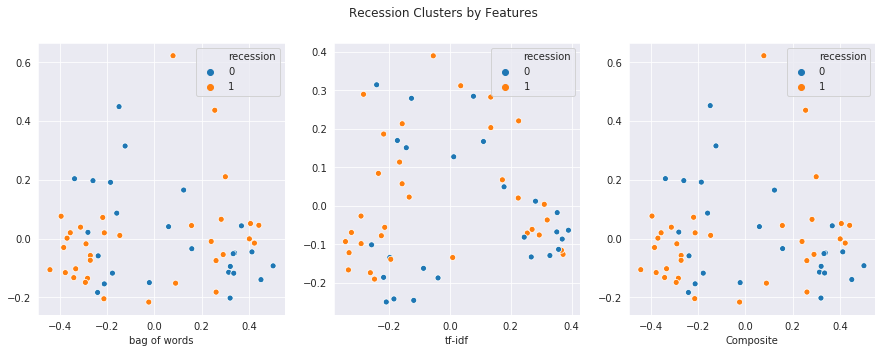

In [0]:
from sklearn.decomposition import PCA
# reduce data to two dimensions
bow_2D_lsa = PCA(n_components=2).fit_transform(Data_bow_lsa)
tfidf_2D_lsa = PCA(n_components=2).fit_transform(Data_tfidf_lsa)
data_2D_lsa = PCA(n_components=2).fit_transform(Data_lsa)

data_list = [bow_2D_lsa, tfidf_2D_lsa, data_2D_lsa]
labels_list = [df_prez['recession'], df_prez['recession'], df_prez['recession']]

def plotting_func(labels_list, data_list=[], num_plots=3, title="placeholder"):
  """
  """
  num_plots = range(0,num_plots)
  
  # plot target variable
  fig, axes = plt.subplots(1, len(num_plots), figsize=(15,5))

  sns.scatterplot(data_list[0][:,0], data_list[0][:,1],
                  hue=labels_list[0], ax=axes[num_plots[0]])
  axes[0].set_xlabel("bag of words")

  sns.scatterplot(data_list[1][:,0], data_list[1][:,1],
                  hue=labels_list[1], ax=axes[num_plots[1]])
  axes[1].set_xlabel("tf-idf")

  sns.scatterplot(data_list[-1][:,0], data_list[-1][:,1],
                  hue=labels_list[-1], ax=axes[num_plots[-1]])
  axes[2].set_xlabel("Composite")

  fig.suptitle(title+" Clusters by Features")
  plt.show;
  
# plot recession target variable
plotting_func(labels_list, data_list, 3, "Recession")

##### K-Means

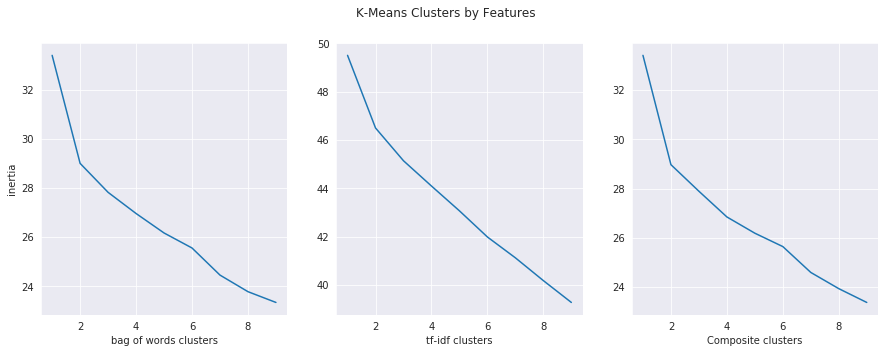

In [0]:
#from sklearn.cluster import KMeans

# Run the Kmeans algorithm and get the index of data points clusters
inertia_bow = []
inertia_tfidf = []
inertia_data = []
k_range = list(range(1, 10))

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    inertia_bow.append(kmeans.fit(Data_bow_lsa).inertia_)
    inertia_tfidf.append(kmeans.fit(Data_tfidf_lsa).inertia_)
    inertia_data.append(kmeans.fit(Data_lsa).inertia_)

# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.lineplot(k_range, inertia_bow, ax=axes[0])
axes[0].set_xlabel("bag of words clusters")
axes[0].set_ylabel("inertia")

sns.lineplot(k_range, inertia_tfidf, ax=axes[1])
axes[1].set_xlabel("tf-idf clusters")

sns.lineplot(k_range, inertia_data, ax=axes[2])
axes[2].set_xlabel("Composite clusters")

fig.suptitle("K-Means Clusters by Features")
plt.show;

In [0]:
# set n_clusters to auto
kmeans = KMeans(max_iter=600, algorithm = 'auto', random_state=42)

new_desc = pd.DataFrame([["recession", "bag of words (lsa)", "kmeans"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(kmeans,
                             Data_bow_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: bag of words (lsa)
Model: kmeans


Training silhouette score: 2.0743

Validation silhouette score: 5.8137

Silhouette score variance: 0.035

Adjusted rand index: 0.0067


In [0]:
new_desc = pd.DataFrame([["recession", "tf-idf (lsa)", "kmeans"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(kmeans,
                             Data_tfidf_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: tf-idf (lsa)
Model: kmeans


Training silhouette score: 1.2687

Validation silhouette score: 2.6526

Silhouette score variance: 0.0048

Adjusted rand index: -0.0091


In [0]:
new_desc = pd.DataFrame([["recession", "composite (lsa)", "kmeans"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(kmeans,
                             Data_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: composite (lsa)
Model: kmeans


Training silhouette score: 2.0722

Validation silhouette score: 5.8093

Silhouette score variance: 0.0349

Adjusted rand index: 0.0067


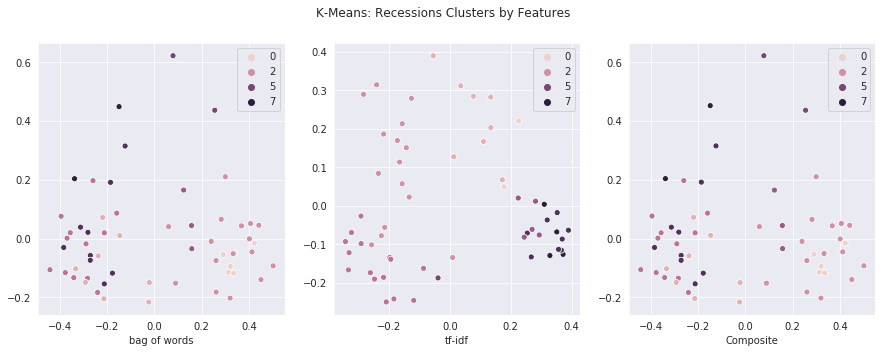

In [0]:
bow_labels_lsa = kmeans.fit(Data_bow_lsa).labels_
tfidf_labels_lsa = kmeans.fit(Data_tfidf_lsa).labels_
data_labels_lsa = kmeans.fit(Data_lsa).labels_

label_list = [bow_labels_lsa, tfidf_labels_lsa, data_labels_lsa]
plotting_func(label_list, data_list, 3, "K-Means: Recessions")

##### Mean Shift

In [0]:
#from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_bow_lsa = estimate_bandwidth(Data_bow_lsa, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_bow_lsa)
bow_labels_lsa = meanshift.fit(Data_bow_lsa).labels_

new_desc = pd.DataFrame([["recession", "bag of words (lsa)", "mean shift"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(meanshift,
                             Data_bow_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: bag of words (lsa)
Model: mean shift



ValueError: ignored

In [0]:
bandwidth_tfidf_lsa = estimate_bandwidth(Data_tfidf_lsa, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_tfidf_lsa)
tfidf_labels_lsa = meanshift.fit(Data_tfidf_lsa).labels_

new_desc = pd.DataFrame([["recession", "tf-idf (lsa)", "mean shift"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(meanshift,
                             Data_tfidf_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: tf-idf (lsa)
Model: mean shift



ValueError: ignored

In [0]:
bandwidth_data_lsa = estimate_bandwidth(Data_lsa, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_data_lsa)
data_labels_lsa = meanshift.fit(Data_lsa).labels_

new_desc = pd.DataFrame([["recession", "composite (lsa)", "mean shift"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(meanshift,
                             Data_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: composite (lsa)
Model: mean shift



ValueError: ignored

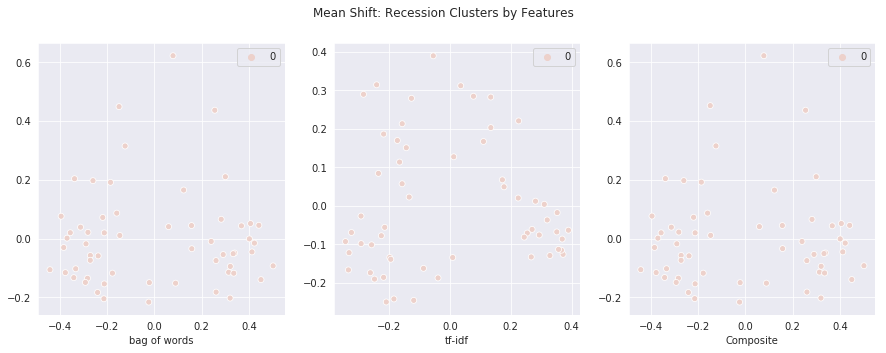

In [0]:
label_list = [bow_labels_lsa, tfidf_labels_lsa, data_labels_lsa]
plotting_func(label_list, data_list, 3, "Mean Shift: Recession")

##### Agglomerative Clustering

In [0]:
#from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2)
new_desc = pd.DataFrame([["recession", "bag of words (lsa)", "agglomerative"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(agg,
                             Data_bow_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: bag of words (lsa)
Model: agglomerative


Training silhouette score: 11.2128

Validation silhouette score: 9.3676

Silhouette score variance: 0.0085

Adjusted rand index: 0.0127


In [0]:
new_desc = pd.DataFrame([["recession", "tf-idf (lsa)", "agglomerative"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(agg,
                             Data_tfidf_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: tf-idf (lsa)
Model: agglomerative


Training silhouette score: 4.8551

Validation silhouette score: 3.2437

Silhouette score variance: 0.0065

Adjusted rand index: 0.0018


In [0]:
new_desc = pd.DataFrame([["recession", "composite (lsa)", "agglomerative"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(agg,
                             Data_lsa,
                             df_prez['recession'],
                             stratify=df_prez['recession'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: recession
Features: composite (lsa)
Model: agglomerative


Training silhouette score: 11.2099

Validation silhouette score: 9.363

Silhouette score variance: 0.0085

Adjusted rand index: 0.0127


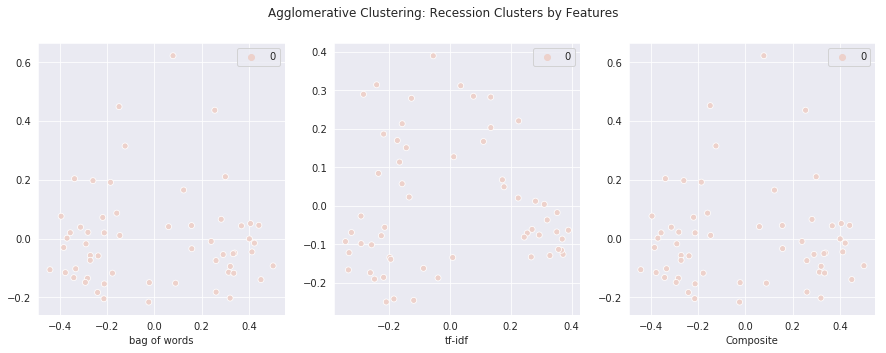

In [0]:
bow_labels_lsa = agg.fit(Data_bow_lsa).labels_
tfidf_labels_lsa = agg.fit(Data_tfidf_lsa).labels_
data_labels_lsa = agg.fit(Data_lsa).labels_

plotting_func(label_list, data_list, 3, "Agglomerative Clustering: Recession")

#### Modeling Wartime

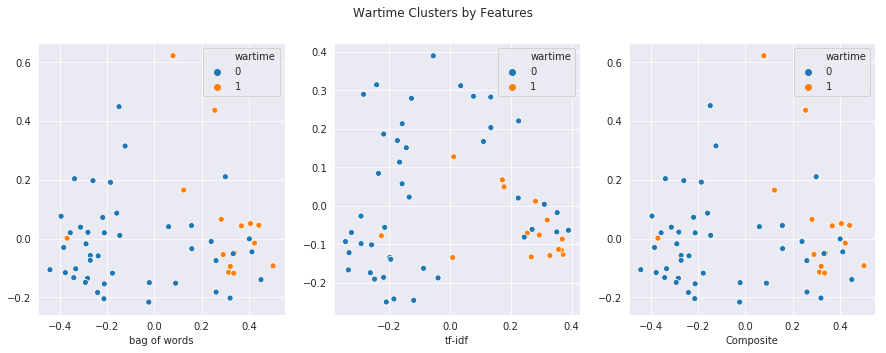

In [0]:
data_list = [bow_2D_lsa, tfidf_2D_lsa, data_2D_lsa]
labels_list = [df_prez['wartime'], df_prez['wartime'], df_prez['wartime']]
# plot recession target variable
plotting_func(labels_list, data_list, 3, "Wartime")

##### K-Means

In [0]:
#from sklearn.cluster import KMeans
kmeans = KMeans(max_iter=600, algorithm = 'auto', random_state=42)

new_desc = pd.DataFrame([["wartime", "bag of words (lsa)", "kmeans"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(kmeans,
                             Data_bow_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: bag of words (lsa)
Model: kmeans


Training silhouette score: 2.7481

Validation silhouette score: 3.2649

Silhouette score variance: 0.0007

Adjusted rand index: 0.0787


In [0]:
new_desc = pd.DataFrame([["wartime", "tf-idf (lsa)", "kmeans"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(kmeans,
                             Data_tfidf_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: tf-idf (lsa)
Model: kmeans


Training silhouette score: 1.1127

Validation silhouette score: 1.7697

Silhouette score variance: 0.0011

Adjusted rand index: 0.1045


In [0]:
new_desc = pd.DataFrame([["wartime", "composite (lsa)", "kmeans"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(kmeans,
                             Data_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: composite (lsa)
Model: kmeans


Training silhouette score: 2.7839

Validation silhouette score: 3.263

Silhouette score variance: 0.0006

Adjusted rand index: 0.0787


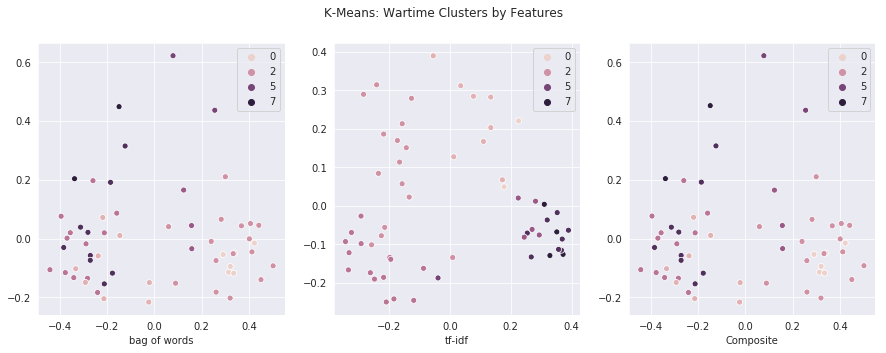

In [0]:
bow_labels_lsa = kmeans.fit(Data_bow_lsa).labels_
tfidf_labels_lsa = kmeans.fit(Data_tfidf_lsa).labels_
data_labels_lsa = kmeans.fit(Data_lsa).labels_

label_list = [bow_labels_lsa, tfidf_labels_lsa, data_labels_lsa]
plotting_func(label_list, data_list, 3, "K-Means: Wartime")

##### Mean Shift

In [0]:
#from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_bow_lsa = estimate_bandwidth(Data_bow_lsa, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_bow_lsa)
bow_labels_lsa = meanshift.fit(Data_bow_lsa).labels_

new_desc = pd.DataFrame([["wartime", "bag of words (lsa)", "mean shift"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(meanshift,
                             Data_bow_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: bag of words (lsa)
Model: mean shift



ValueError: ignored

In [0]:
bandwidth_tfidf_lsa = estimate_bandwidth(Data_tfidf_lsa, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_tfidf_lsa)
tfidf_labels_lsa = meanshift.fit(Data_tfidf_lsa).labels_

new_desc = pd.DataFrame([["wartime", "tf-idf (lsa)", "mean shift"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(meanshift,
                             Data_tfidf_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: tf-idf (lsa)
Model: mean shift



ValueError: ignored

In [0]:
bandwidth_data_lsa = estimate_bandwidth(Data_lsa, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_data_lsa)
data_labels_lsa = meanshift.fit(Data_lsa).labels_

new_desc = pd.DataFrame([["wartime", "composite (lsa)", "mean shift"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(meanshift,
                             Data_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: composite (lsa)
Model: mean shift



ValueError: ignored

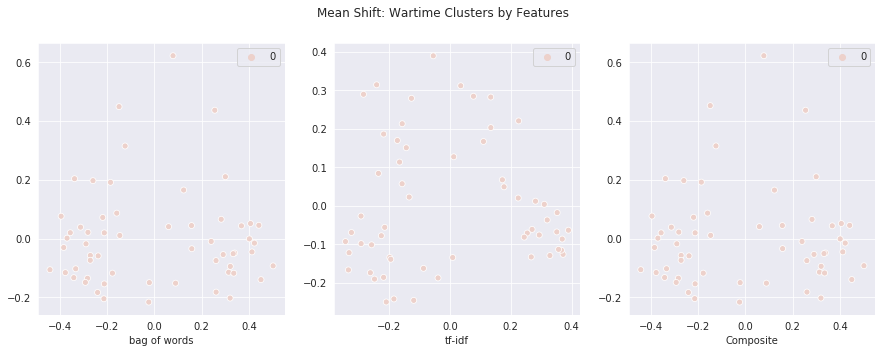

In [0]:
label_list = [bow_labels_lsa, tfidf_labels_lsa, data_labels_lsa]
plotting_func(label_list, data_list, 3, "Mean Shift: Wartime")

##### Agglomerative Clustering

In [0]:
#from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2)
new_desc = pd.DataFrame([["wartime", "bag of words (lsa)", "agglomerative"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(agg,
                             Data_bow_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: bag of words (lsa)
Model: agglomerative


Training silhouette score: 10.4589

Validation silhouette score: 12.6874

Silhouette score variance: 0.0124

Adjusted rand index: 0.1313


In [0]:
new_desc = pd.DataFrame([["wartime", "tf-idf (lsa)", "agglomerative"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(agg,
                             Data_tfidf_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: tf-idf (lsa)
Model: agglomerative


Training silhouette score: 4.355

Validation silhouette score: 4.1484

Silhouette score variance: 0.0001

Adjusted rand index: 0.1597


In [0]:
new_desc = pd.DataFrame([["wartime", "composite (lsa)", "agglomerative"]],
                        columns=["target", "features", "model"])
cluster_desc = cluster_desc.append(new_desc, ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

new_score = unsupervised_clf(agg,
                             Data_lsa,
                             df_prez['wartime'],
                             stratify=df_prez['wartime'])
cluster_score = cluster_score.append(new_score, ignore_index=True)

Target: wartime
Features: composite (lsa)
Model: agglomerative


Training silhouette score: 10.4516

Validation silhouette score: 12.6812

Silhouette score variance: 0.0124

Adjusted rand index: 0.1313


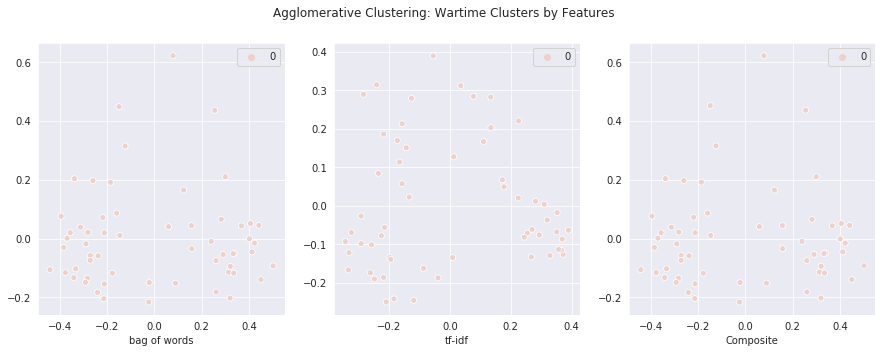

In [0]:
bow_labels_lsa = agg.fit(Data_bow_lsa).labels_
tfidf_labels_lsa = agg.fit(Data_tfidf_lsa).labels_
data_labels_lsa = agg.fit(Data_lsa).labels_

plotting_func(label_list, data_list, 3, "Agglomerative Clustering: Wartime")

#### Assessment

In [0]:
cluster_score.describe()

,train_sil_score,test_sil_score,sil_var,ARI
count,12.000000,12.000000,12.000000,12.000000
mean,5.383600,6.172042,0.010458,0.059642
std,4.172421,3.894334,0.012247,0.061129
min,1.112700,1.769700,0.000100,-0.009100
25%,2.073775,3.258175,0.001000,0.006700
50%,3.569450,4.978850,0.007500,0.045700
75%,10.453425,9.364150,0.012400,0.111200
max,11.212800,12.687400,0.035000,0.159700


In [0]:
df_test = pd.concat([cluster_desc, cluster_score], axis=1)
df_test.sort_values(by=["ARI"], ascending=False).head()

,target,features,model,train_sil_score,test_sil_score,sil_var,ARI
10,wartime,bag of words (lsa),kmeans,4.3550,4.1484,0.0001,0.1597
9,recession,composite (lsa),agglomerative,10.4589,12.6874,0.0124,0.1313
11,wartime,tf-idf (lsa),kmeans,10.4516,12.6812,0.0124,0.1313
7,recession,bag of words (lsa),agglomerative,1.1127,1.7697,0.0011,0.1045
6,recession,composite (lsa),mean shift,2.7481,3.2649,0.0007,0.0787


Dimensionality reduction had no real effect on clustering models. Overall, ARI scores aren't  higher and models did not exhibit any stronger classification power.

### Model Tuning: Supervised

In [0]:
# define dataframes to store results
df_desc = pd.DataFrame()
df_score = pd.DataFrame()

# define supervised modeling function
def supervised_clf(model, data, target, test_size=0.25, stratify=None, cv=5):
  """
  """
  #from sklearn.model_selection import train_test_split, cross_val_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  model = model.fit(X_train, y_train)
  train_score = model.score(X_train, y_train)
  test_score = model.score(X_test, y_test)
  print('\nTraining score:', train_score)
  print('\nValidation score:', test_score)
  
  cv_scores = cross_val_score(model, data, target, cv=cv)
  cv_score = np.round(np.mean(cv_scores)*100, 4)
  variance = np.round(np.var(cv_scores)*100, 4)
  print('\nCross validation: {} +/- {}%'.format(cv_score, variance))
  
  return pd.DataFrame([[train_score, test_score, cv_score, variance]],
                      columns=["train_score", "test_score", "cv_score", "variance"])

#### Modeling Recessions

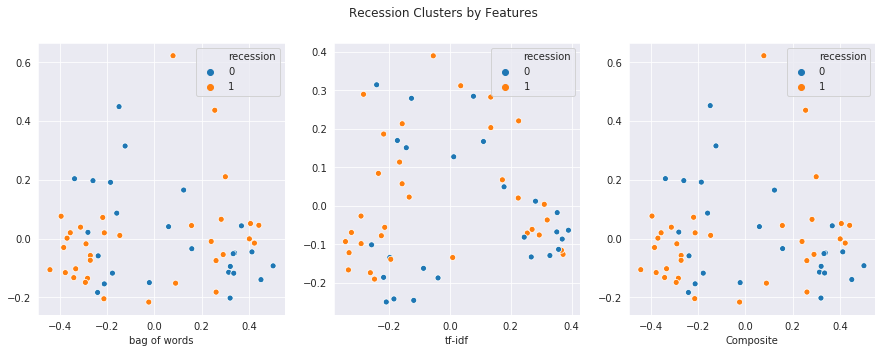

In [0]:
data_list = [bow_2D_lsa, tfidf_2D_lsa, data_2D_lsa]
labels_list = [df_prez['recession'], df_prez['recession'], df_prez['recession']]
# plot wartime target variable
plotting_func(labels_list, data_list, 3, "Recession")

##### Random Forest

In [0]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
new_desc = pd.DataFrame([["recession", "bag of words (lsa)", "random forest"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=rfc,
                           data=Data_bow_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: bag of words (lsa)
Model: random forest


Training score: 1.0

Validation score: 0.6666666666666666

Cross validation: 58.4848 +/- 0.5266%


In [0]:
new_desc = pd.DataFrame([["recession", "tf-idf (lsa)", "random forest"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=rfc,
                           data=Data_tfidf_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score , ignore_index=True)

Target: recession
Features: tf-idf (lsa)
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 63.3333 +/- 1.3604%


In [0]:
new_desc = pd.DataFrame([["recession", "composite (lsa)", "random forest"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=rfc,
                           data=Data_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: composite (lsa)
Model: random forest


Training score: 1.0

Validation score: 0.6666666666666666

Cross validation: 58.4848 +/- 0.5266%


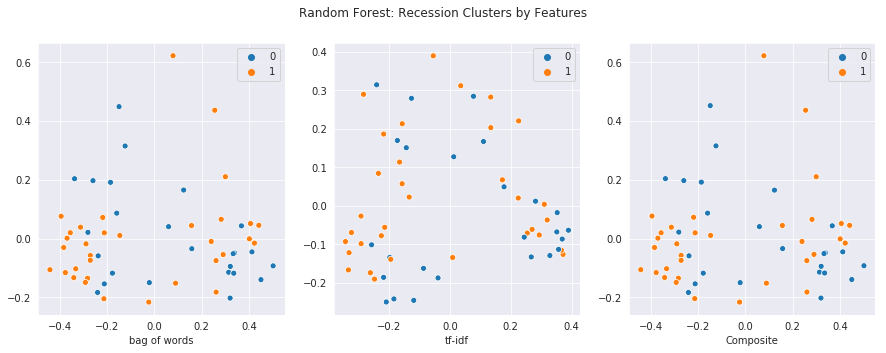

In [0]:
pred_bow = rfc.fit(Data_bow_lsa, df_prez['recession']).predict(Data_bow_lsa)
pred_tfidf = rfc.fit(Data_tfidf_lsa, df_prez['recession']).predict(Data_tfidf_lsa)
pred_data = rfc.fit(Data_lsa, df_prez['recession']).predict(Data_lsa)
labels_list = [pred_bow, pred_tfidf, pred_data]

plotting_func(labels_list, data_list, 3, "Random Forest: Recession")

##### Support Vector Machines

In [0]:
#from sklearn.svm import SVC
# set gamma to 'scale'
svc = SVC(gamma='scale', random_state=42)
new_desc = pd.DataFrame([["recession", "bag of words (lsa)", "svm"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=svc,
                           data=Data_bow_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: bag of words (lsa)
Model: svm


Training score: 0.9302325581395349

Validation score: 0.5333333333333333

Cross validation: 62.2727 +/- 0.9766%


In [0]:
new_desc = pd.DataFrame([["recession", "tf-idf (lsa)", "svm"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=svc,
                           data=Data_tfidf_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: tf-idf (lsa)
Model: svm


Training score: 1.0

Validation score: 0.6

Cross validation: 56.8182 +/- 0.0344%


In [0]:
new_desc = pd.DataFrame([["recession", "composite (lsa)", "svm"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=svc,
                           data=Data_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: composite (lsa)
Model: svm


Training score: 0.9302325581395349

Validation score: 0.5333333333333333

Cross validation: 62.2727 +/- 0.9766%


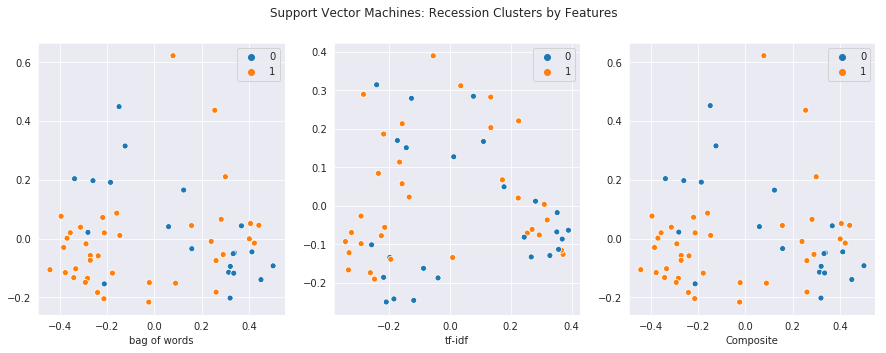

In [0]:
pred_bow = svc.fit(Data_bow_lsa, df_prez['recession']).predict(Data_bow_lsa)
pred_tfidf = svc.fit(Data_tfidf_lsa, df_prez['recession']).predict(Data_tfidf_lsa)
pred_data = svc.fit(Data_lsa, df_prez['recession']).predict(Data_lsa)
labels_list = [pred_bow, pred_tfidf, pred_data]

plotting_func(labels_list, data_list, 3, "Support Vector Machines: Recession")

##### SGD Classifier

In [0]:
#from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
new_desc = pd.DataFrame([["recession", "bag of words (lsa)", "sgd"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=sgd,
                           data=Data_bow_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: bag of words (lsa)
Model: sgd


Training score: 1.0

Validation score: 0.5333333333333333

Cross validation: 49.8485 +/- 0.4991%


In [0]:
new_desc = pd.DataFrame([["recession", "tf-idf (lsa)", "sgd"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=sgd,
                           data=Data_tfidf_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: tf-idf (lsa)
Model: sgd


Training score: 1.0

Validation score: 0.6

Cross validation: 51.5152 +/- 0.668%


In [0]:
new_desc = pd.DataFrame([["recession", "composite (lsa)", "sgd"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=sgd,
                           data=Data_lsa,
                           target=df_prez['recession'],
                           stratify=df_prez['recession'])
df_score = df_score.append(new_score, ignore_index=True)

Target: recession
Features: composite (lsa)
Model: sgd


Training score: 1.0

Validation score: 0.5333333333333333

Cross validation: 51.8182 +/- 1.2135%


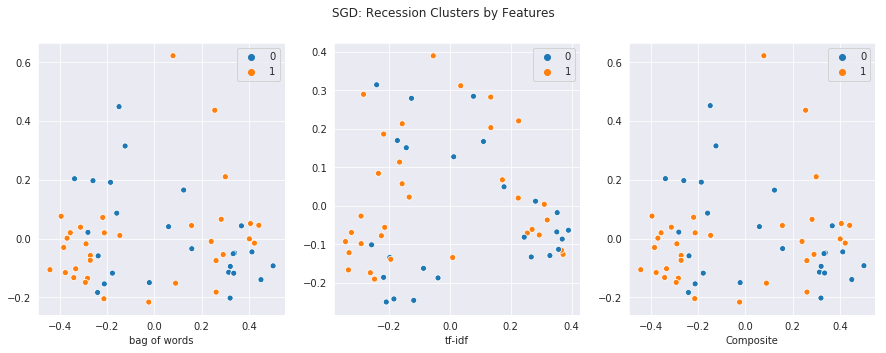

In [0]:
pred_bow = sgd.fit(Data_bow_lsa, df_prez['recession']).predict(Data_bow_lsa)
pred_tfidf = sgd.fit(Data_tfidf_lsa, df_prez['recession']).predict(Data_tfidf_lsa)
pred_data = sgd.fit(Data_lsa, df_prez['recession']).predict(Data_lsa)
labels_list = [pred_bow, pred_tfidf, pred_data]

plotting_func(labels_list, data_list, 3, "SGD: Recession")

#### Modeling Wartime

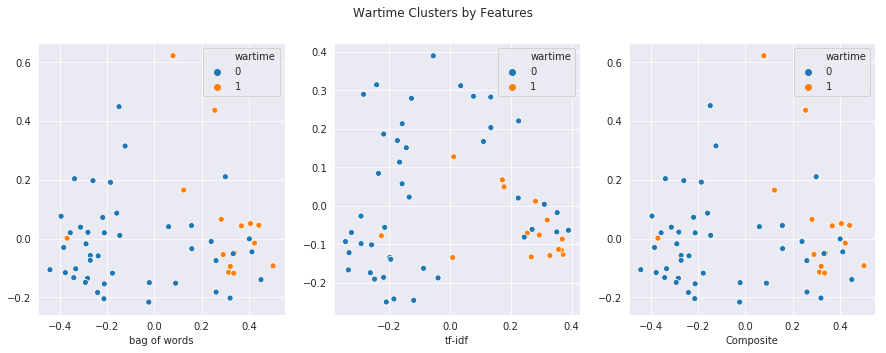

In [0]:
data_list = [bow_2D_lsa, tfidf_2D_lsa, data_2D_lsa]
labels_list = [df_prez['wartime'], df_prez['wartime'], df_prez['wartime']]
# plot wartime target variable
plotting_func(labels_list, data_list, 3, "Wartime")

##### Random Forest

In [0]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
new_desc = pd.DataFrame([["wartime", "bag of words (lsa)", "random forest"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=rfc,
                           data=Data_bow_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: bag of words (lsa)
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 73.9394 +/- 0.3962%


In [0]:
new_desc = pd.DataFrame([["wartime", "tf-idf (lsa)", "random forest"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=rfc,
                           data=Data_tfidf_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score , ignore_index=True)

Target: wartime
Features: tf-idf (lsa)
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [0]:
new_desc = pd.DataFrame([["wartime", "composite (lsa)", "random forest"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=rfc,
                           data=Data_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: composite (lsa)
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 73.9394 +/- 0.3962%


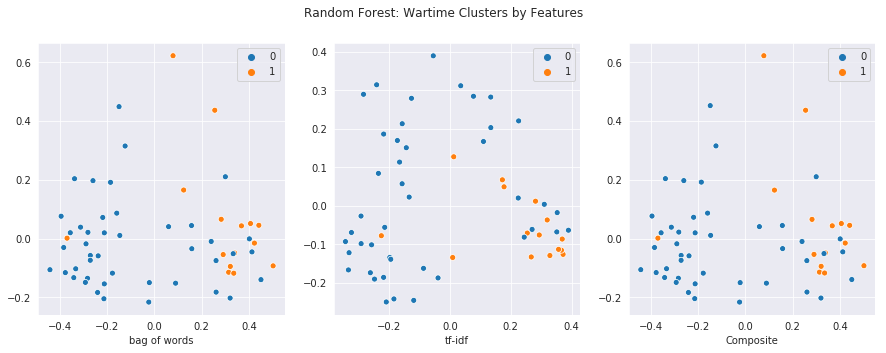

In [0]:
pred_bow = rfc.fit(Data_bow_lsa, df_prez['wartime']).predict(Data_bow_lsa)
pred_tfidf = rfc.fit(Data_tfidf_lsa, df_prez['wartime']).predict(Data_tfidf_lsa)
pred_data = rfc.fit(Data_lsa, df_prez['wartime']).predict(Data_lsa)
labels_list = [pred_bow, pred_tfidf, pred_data]

plotting_func(labels_list, data_list, 3, "Random Forest: Wartime")

##### Support Vector Machines

In [0]:
#from sklearn.svm import SVC
# set gamma to 'scale'
svc = SVC(gamma='scale', random_state=42)
new_desc = pd.DataFrame([["wartime", "bag of words (lsa)", "svm"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=svc,
                           data=Data_bow_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: bag of words (lsa)
Model: svm


Training score: 0.9767441860465116

Validation score: 0.7333333333333333

Cross validation: 65.0 +/- 3.5661%


In [0]:
new_desc = pd.DataFrame([["wartime", "tf-idf (lsa)", "svm"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=svc,
                           data=Data_tfidf_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: tf-idf (lsa)
Model: svm


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 74.0909 +/- 0.0124%


In [0]:
new_desc = pd.DataFrame([["wartime", "composite (lsa)", "svm"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=svc,
                           data=Data_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: composite (lsa)
Model: svm


Training score: 0.9767441860465116

Validation score: 0.7333333333333333

Cross validation: 65.0 +/- 3.5661%


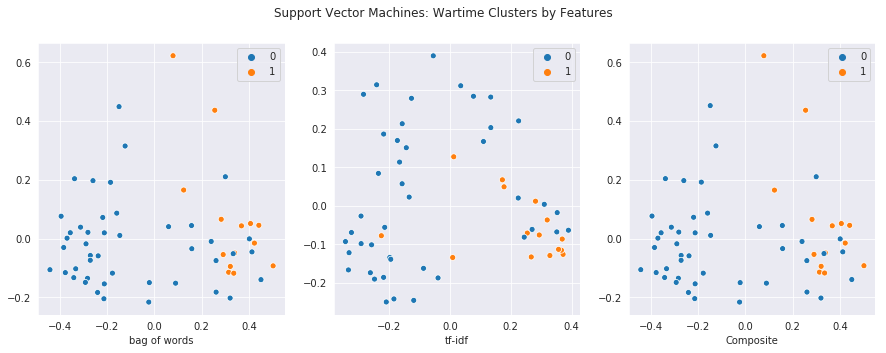

In [0]:
pred_bow = svc.fit(Data_bow_lsa, df_prez['wartime']).predict(Data_bow_lsa)
pred_tfidf = svc.fit(Data_tfidf_lsa, df_prez['wartime']).predict(Data_tfidf_lsa)
pred_data = svc.fit(Data_lsa, df_prez['wartime']).predict(Data_lsa)
labels_list = [pred_bow, pred_tfidf, pred_data]

plotting_func(labels_list, data_list, 3, "Support Vector Machines: Wartime")

##### SGD Classifier

In [0]:
#from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
new_desc = pd.DataFrame([["wartime", "bag of words (lsa)", "sgd"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=sgd,
                           data=Data_bow_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: bag of words (lsa)
Model: sgd


Training score: 1.0

Validation score: 1.0

Cross validation: 70.0 +/- 5.0106%


In [0]:
new_desc = pd.DataFrame([["wartime", "tf-idf (lsa)", "sgd"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=sgd,
                           data=Data_tfidf_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: tf-idf (lsa)
Model: sgd


Training score: 1.0

Validation score: 0.8666666666666667

Cross validation: 75.303 +/- 3.9109%


In [0]:
new_desc = pd.DataFrame([["wartime", "composite (lsa)", "sgd"]],
                        columns=["target", "features", "model"])
df_desc = df_desc.append(new_desc, ignore_index=True)
print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    df_desc["target"].iloc[-1], df_desc["features"].iloc[-1], df_desc["model"].iloc[-1]))
new_score = supervised_clf(model=sgd,
                           data=Data_lsa,
                           target=df_prez['wartime'],
                           stratify=df_prez['wartime'])
df_score = df_score.append(new_score, ignore_index=True)

Target: wartime
Features: composite (lsa)
Model: sgd


Training score: 1.0

Validation score: 1.0

Cross validation: 68.1818 +/- 5.877%


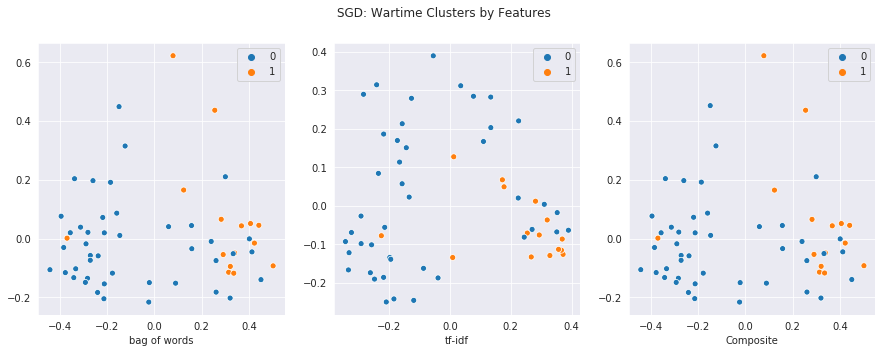

In [0]:
pred_bow = sgd.fit(Data_bow_lsa, df_prez['wartime']).predict(Data_bow_lsa)
pred_tfidf = sgd.fit(Data_tfidf_lsa, df_prez['wartime']).predict(Data_tfidf_lsa)
pred_data = sgd.fit(Data_lsa, df_prez['wartime']).predict(Data_lsa)
labels_list = [pred_bow, pred_tfidf, pred_data]

plotting_func(labels_list, data_list, 3, "SGD: Wartime")

#### Assessment

In [0]:
df_score[["cv_score", "variance"]].describe()

,cv_score,variance
count,18.000000,18.000000
mean,64.132989,1.640539
std,8.427961,1.858621
min,49.848500,0.012400
25%,58.484800,0.421925
50%,64.166650,0.822300
75%,72.954550,3.014675
max,75.303000,5.877000


In [0]:
df_test = pd.concat([df_desc, df_score], axis=1)
df_test.sort_values(by=["cv_score"], ascending=False).head()

,target,features,model,train_score,test_score,cv_score,variance
16,wartime,tf-idf (lsa),sgd,1.0,0.866667,75.3030,3.9109
10,wartime,tf-idf (lsa),random forest,1.0,0.733333,74.0909,0.0124
13,wartime,tf-idf (lsa),svm,1.0,0.733333,74.0909,0.0124
9,wartime,bag of words (lsa),random forest,1.0,0.733333,73.9394,0.3962
11,wartime,composite (lsa),random forest,1.0,0.733333,73.9394,0.3962


Overall reducing the dimensionality of the data had no real effect on increasing model performance or decreasing variance. The Random Forest classifier is still the strongest performaning model, using the tf-idf feature set to classifiy the wartime target value.

### Hyperparmeter Optimization

In [0]:
#from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    "wartime", "tf-idf", "random forest"))
supervised_clf(model=rfc,
               data=Data_tfidf,
               target=df_prez['wartime'],
               stratify=df_prez['wartime'])

print("\nParameters:")
rfc.get_params()

Target: wartime
Features: tf-idf
Model: random forest


Training score: 1.0

Validation score: 0.8

Cross validation: 74.0909 +/- 0.0124%

Parameters:


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [0]:
Data = Data_tfidf
target = df_prez['wartime']

# split data 
X_train, X_test, y_train, y_test = train_test_split(
    Data, target, test_size=0.25, stratify=target, random_state=42)

# sample data for parameter search
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42, stratify=y_train)

In [0]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rfc = RandomForestClassifier()

rfc_rs = RandomizedSearchCV(rfc, param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rfc_rs.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   54.6s


CPU times: user 2.53 s, sys: 172 ms, total: 2.71 s
Wall time: 1min 41s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
rfc_rs.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [0]:
best_params = rfc_rs.best_params_

rfc = RandomForestClassifier(**best_params, random_state=42)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    "wartime", "tf-idf", "random forest"))
supervised_clf(model=rfc,
               data=Data_tfidf,
               target=df_prez['wartime'],
               stratify=df_prez['wartime'])

Target: wartime
Features: tf-idf
Model: random forest


Training score: 1.0

Validation score: 0.7333333333333333

Cross validation: 75.9091 +/- 0.095%


,train_score,test_score,cv_score,variance
0,1.0,0.733333,75.9091,0.095


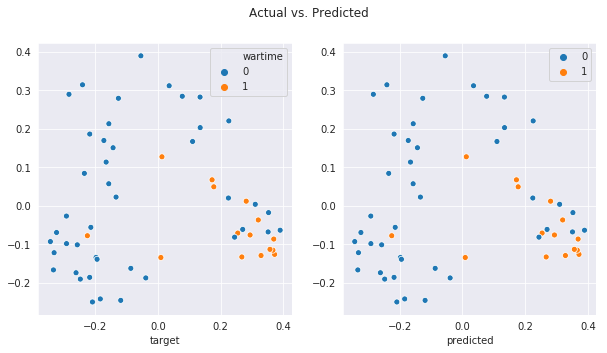

In [0]:
y_pred = rfc.fit(Data_tfidf, target).predict(Data_tfidf)

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.scatterplot(tfidf_2D_lsa[:,0], tfidf_2D_lsa[:,1],
                hue=target, ax=axes[0])
axes[0].set_xlabel("target")

sns.scatterplot(tfidf_2D_lsa[:,0], tfidf_2D_lsa[:,1],
                hue=y_pred, ax=axes[1])
axes[1].set_xlabel("predicted")

fig.suptitle("Actual vs. Predicted")
plt.show;

After optimization the Random Forest classifier had slightly improved performance with decreased variance. Overall, our model was able to predict periods of war from inaugural addresses with approximately 73% accuracy.

## Conclusion

Overall, our varying approachs in modeling our target values and features sets had mixed perfomance. The clustering models almost universally had difficultly detecting patterns in the data and the supervised models were able to classify the data, but not with high confidence. Ultimately, the strongest model was using supervised methods (random forest classifier) to classify the wartime target variable across the tf-idf feature set.

This is interesting because in my experience common words (bag-of-words) is usally a more accurate way of classifying texts than infrequent words (tf-idf). It's also interesting that the models had such difficultly detecting patterns in the data based on the occurance of recessions. This could be for two reasons: recessions are [rather frequent](https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States) in American history, and--*possibly*--because people would rather talk about positive things than negative things. 

While the state of the economy affects the lives of every American citizen, it could be that people would rather not talk about it when things aren't going very well. Where as war, while desvastatingly tragic, could be used to rally and galvanize the country. Exactly what a president might hope to do with their inaugural address.

This could also explain why the *infrequent* words did such a better job of classifying the texts than common words. Once you strip each inaugural address down to its roots, they're all kind of... the same. Words like "government",	"people",	"nation",	"country", and "citizen" come up a lot. For the most part, the president's talking about the same stuff. It's only during specific times that the president talks about specific things, like war.

It would be interesting to compare this approach to other presidential speaches, such as the state of the union. Are there patterns that inaugural addresses follow that the state of the union doesn't? Is the president more or less likely to talk about hard topics like the economy during the state of the union? 

It would also be interesting to use more advanced techniques, such as using deep learning to generate contextual embeddings of the text. Maybe the president doesn't like talking about the economy, but still gives away hints in the context of the speach. An inaugural address with an overal negative context is potentially much more likely to occur during a time of war or a declining economy.

Another application of this model could be to analyze similar types of text. For example a CEO's letter to shareholders is unlikely to mention hard topics such as declining profits or changes in the economy. Rather, these are more likely the most positvie portrayal of the company possible. Perhaps the CEO gives away certain clues in the language that will give away the true nature of the state of the company?

This was a very interesting excerise that shows the usefulness of using multiple approaches to solve the same problem. If I trusted my intuition, I would have only looked at common words and that ultimately wouldn't have resulted in a very strong model. I guess sometimes it's not what you say, but what you *don't* say that matters.